<a href="https://colab.research.google.com/github/jan-kreischer/UZH_Network-Science_Final-Project/blob/main/index_tmp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project on Epidemics on Networks

## 1. Setup
### 1.1 Dependencies
Installing all dependencies needed to run the simulations

In [1]:
! pip install EoN
! pip install PySPG
! pip install powerlaw
! pip install tenacity

     |████████████████████████████████| 113 kB 5.5 MB/s 
  Created wheel for EoN: filename=EoN-1.1-py3-none-any.whl size=120819 sha256=b7f6d9307934947de5b1d1c69131c7f716d6c503ef3b597871695ccbe717c0ad
  Stored in directory: /root/.cache/pip/wheels/0b/c0/a4/d6001fd809cb84c027ada5c2ab3b6d1cb2e97fec3f9978eae7
Successfully built EoN
     |████████████████████████████████| 76 kB 2.5 MB/s 


### 1.2 Imports

In [2]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import networkx as nx
import math as m

from tabulate import tabulate

from tenacity import retry

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import torch
from collections import defaultdict
import random

import random as rnd
from random import shuffle

import powerlaw
import EoN

### 1.3 Constants

In [ ]:
n_switzerland = 8.6 * (10**6)
n_canton_zurich = 1.5* (10**6)
n_zurich_city = 400000
n_uzh = 26000
n_ifi = 3000
n_ns_class = 150

DEFAULT_INFECTION_RATE = 0.25
DEFAULT_RECOVERY_RATE = 1
DEFAULT_INITIAL_SIZE = 1

N_ITERATIONS = 10

TMIN = 30 # Minimum Report Time
TMAX = 30 # Maximum Report Time

S_COLOR = "blue"
S_LINESTYLE = "dotted"
S_LABEL = "Susceptible"

I_COLOR = "crimson"
I_LINESTYLE = "dashed"
I_LABEL = "Infected"

R_COLOR = "lime"
R_LINESTYLE = 'solid'
R_LABEL = 'Recovered'

### 1.4 Environment
We check if the environment we are using is properly setup, such that we are using GPU for training our models.  
Furthermore the data stored in google drive is made accessible.

In [ ]:
# Check Memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Enable access to files stored in Google Drive
from google.colab import drive
# Leave this like it is
mountpoint = '/content/drive/' 
drive.mount(mountpoint)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Adapt this path to the folder where your data is stored in google drive
data_path = 'My Drive/UZH_Network-Science/Projects/Final-Project/data' 
complete_path = os.path.join(mountpoint, data_path)
# Cd into the directory with the git repo
% cd $complete_path

/content/drive/My Drive/UZH_Network-Science/Projects/Final-Project/data


### 1.5 Functions
#### 1.5.1 Self Defined Functions

In [ ]:
def average(lst):
    return sum(lst)/len(lst)

In [ ]:
def load_graph(graph_name):
  graph = nx.read_gml(graph_name)
  return graph


#### 1.5.2 EoN Library Functions
*EoN.Gillespie_SIR(**G**, **tau**, **gamma**, **initial_infecteds**=None, **initial_recovereds**=None, **rho**=None, **tmin**=0, **tmax**=inf, **recovery_weight**=None, **transmission_weight**=None, **return_full_data**=False, **sim_kwargs**=None)*
- **G** ... [networkx Graph] representing the underlying network
- **tau** ... [positive float] transmission rate per edge
- **gamma** ... [number] recovery rate per node
- **initial_infecteds** ... node or iterable of nodes if a single node, then this node is initially infected if an iterable, then whole set is initially infected if None, then choose randomly based on rho. If rho is also None, a random single node is chosen. If both initial_infecteds and rho are assigned, then there is an error.
- **initial_recovereds** ... iterable of nodes (default None)
this whole collection is made recovered. Currently there is no test for consistency with initial_infecteds. Understood that everyone who isn’t infected or recovered initially is initially susceptible.
- **rho** ... number initial fraction infected. number is int(round(G.order()*rho))
- **tmin** ... number (default 0) starting time
- **tmax** ... number (default Infinity) stop time
- **recovery_weight** ... string (default None) the string used to define the node attribute for the weight. Assumes that the recovery rate is gamma*G.nodes[u][recovery_weight]. If None, then just uses gamma without scaling.
- **transmission_weight** ... string (default None)
the string used to define the edge attribute for the weight. Assumes that the transmission rate from u to v is tau*G.adj[u][v][transmission_weight] If None, then just uses tau without scaling.
- **return_full_data** ... boolean (default False)
Tells whether a Simulation_Investigation object should be returned.
- **sim_kwargs** ... keyword arguments Any keyword arguments to be sent to the Simulation_Investigation object Only relevant if return_full_data=True

## 2. Graphs
### 2.1 Graph Metrics

In [ ]:
def plot_degree_distribution(graph, graph_name, i, xscale='linear', yscale='linear', n_bins=20, density=True, ):
    plt.subplot(1, 3, i)
    graph_degrees = graph.degree()
    graph_degrees = [graph_degrees[i] for i in graph.nodes()]
    #fig, ax = plt.subplots()
    title = "{}\nDegree Distribution ".format(graph_name)

    if xscale == 'log':
        title+="Log"
        bins = np.logspace(np.log10(min(graph_degrees)),np.log10(max(graph_degrees)), n_bins)
        plt.hist(graph_degrees, bins=bins, density = density, alpha=0.5)
        plt.xlabel('log k')
    else:
        title+="Lin"
        bins = np.linspace(0, max(graph_degrees), n_bins)
        plt.hist(graph_degrees, bins = bins, density = density, alpha=0.5)
        plt.xlabel('k')
        
    if yscale == 'log':
        plt.ylabel("log P(k)")
        title+="-Log Scale"
    else:
        plt.ylabel("P(k)")
        title+="-Lin Scale"
    
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.title(title)
  

In [ ]:
def plot_degree_distributions(graph, graph_name, n_bins=20, density=True):
  fig, axis = plt.subplots(1,3,figsize=(15,4))
  plot_degree_distribution(graph, graph_name, 1, xscale='linear', yscale='linear', n_bins=n_bins, density=density)
  plot_degree_distribution(graph, graph_name, 2, xscale='log', yscale='linear', n_bins=n_bins, density=density)
  plot_degree_distribution(graph, graph_name, 3, xscale='log', yscale='log', n_bins=n_bins, density=density)
  plt.show()

In [ ]:
#Compute average degree <k> of the graph
def get_average_degree(graph):
    graph_degrees = graph.degree()
    graph_degrees = [graph_degrees[i] for i in graph.nodes()]
    n_edges = sum(graph_degrees)
    n_nodes = len(graph.nodes())
    average_degree = n_edges / n_nodes
    return average_degree

In [ ]:
def quantify_graph(graph):
  number_of_nodes = graph.number_of_nodes()
  number_of_edges = graph.number_of_edges()
  avg_degree = get_average_degree(graph)
  average_clustering_coefficient = nx.average_clustering(graph)
  degree_assortativity_coefficient = nx.degree_assortativity_coefficient(graph, weight = None)
  is_weighted = nx.is_weighted(graph)
  is_directed = nx.is_directed(graph)
  is_connected = nx.is_connected(graph)
  
  density = nx.density(graph)
  if is_connected:
    diameter = nx.diameter(graph)

  graph_degrees = graph.degree()
  degrees = [graph_degrees[i] for i in graph.nodes()]
  
  print("Number of Nodes: {}".format(number_of_nodes))
  print("Number of Edges: {}".format(number_of_edges))

  print("Is directed: {}".format(is_directed))
  print("Is weighted: {}".format(is_weighted))
  print("Is connected: {}".format(is_connected))

  print("Density: {}%".format(round(density*100, 4)))
  if is_connected:
    print("Diameter: {}".format(diameter))

  print("Min Node Degree: {}".format(min(degrees)))
  print("Max Node Degree: {}".format(max(degrees)))
  print("Average Node Degree: <k> ≈ {}".format(round(avg_degree, 2)))
  print("Average Clustering Coefficient: {}".format(round(average_clustering_coefficient, 4)))
  print("Degree Assortativity Coefficient: {}".format(round(degree_assortativity_coefficient, 4)))
  deg = np.asarray([d for d in dict(graph.degree()).values()])
  
  results = powerlaw.Fit(deg, discrete=True, verbose=False) #
  gamma = results.power_law.alpha # Although the powerlaw package calls the exponent alpha we called it gamma in our formula
  print("Fitted power law-exponent: Ɣ ≈ {}".format(round(gamma, 2)))
  sigma = results.power_law.sigma
  print('Standard error of fit: σ ≈ {}'.format(round(sigma, 4)))
    
  #Plot the degree distribution (histogram & log-log scale) 
  average_degree = get_average_degree(graph)
  #plot_distributions(degrees, average_degree)

### 2.2 Synthetic Graphs  

In [ ]:
number_of_nodes = 1000
average_degree = 10

#### 2.2.1 Barabási-Albert graph
*barabasi_albert_graph(n, m, seed=None)*.  
n ... [int] ... Number of nodes.  
m ... [int] ... Number of edges to attach from a new node to existing nodes.

In [ ]:
def barabasi_albert_graph(number_of_nodes, average_degree):
  return nx.barabasi_albert_graph(number_of_nodes, int(average_degree/2))

In [ ]:
ba_n_1000_k_10 = barabasi_albert_graph(number_of_nodes, average_degree)
quantify_graph(ba_n_1000_k_10)

Number of Nodes: 1000
Number of Edges: 4975
Is directed: False
Is weighted: False
Is connected: True
Density: 0.996%
Diameter: 5
Min Node Degree: 5
Max Node Degree: 136
Average Node Degree: <k> ≈ 9.95
Average Clustering Coefficient: 0.0404
Degree Assortativity Coefficient: -0.0551
Fitted power law-exponent: Ɣ ≈ 2.72
Standard error of fit: σ ≈ 0.0543


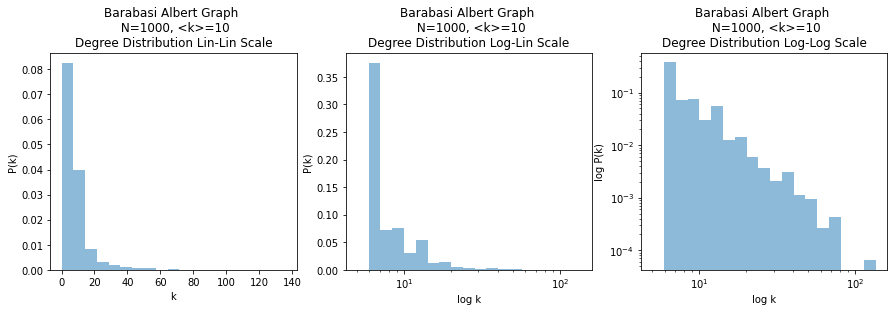

In [ ]:
plot_degree_distributions(ba_n_1000_k_10, "Barabasi Albert Graph \n N=1000, <k>=10", n_bins=20, density=True)

#### 2.2.2 Erdős-Rényi graph
*erdos_renyi_graph(n, p, seed=None, directed=False)*.  
The  model chooses each of the possible edges with probability p.  
n ... Number of nodes. 
p ... Probability of edge creation. 

In [ ]:
def erdos_renyi_graph(number_of_nodes, average_degree):
  return nx.erdos_renyi_graph(number_of_nodes, average_degree/number_of_nodes, directed=False)

In [ ]:
er_n_1000_k_10 = erdos_renyi_graph(number_of_nodes, average_degree)
quantify_graph(er_n_1000_k_10)

Number of Nodes: 1000
Number of Edges: 4979
Is directed: False
Is weighted: False
Is connected: True
Density: 0.9968%
Diameter: 5
Min Node Degree: 2
Max Node Degree: 20
Average Node Degree: <k> ≈ 9.96
Average Clustering Coefficient: 0.0096
Degree Assortativity Coefficient: 0.0012
Fitted power law-exponent: Ɣ ≈ 9.67
Standard error of fit: σ ≈ 0.7755


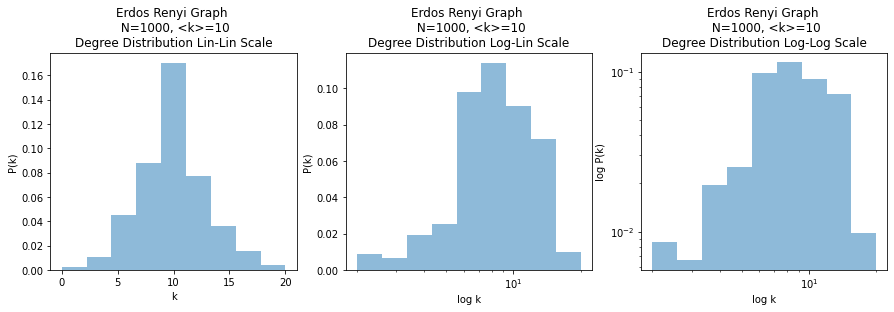

In [ ]:
plot_degree_distributions(er_n_1000_k_10, "Erdos Renyi Graph \n N=1000, <k>=10", n_bins=10, density=True)

#### 2.2.3 Watts Strogatz graph
*watts_strogatz_graph(n, k, p, seed=None)*.  
n ... [int] ... The number of nodes.  
k ... [int] ... Each node is connected to k nearest neighbors in ring topology.  
p ... [float] ... The probability of rewiring each edge.  
seed ..[int] ...optional Seed for random number generator (default=None)  


In [ ]:
def watts_strogatz_graph(number_of_nodes, average_degree):
  return nx.watts_strogatz_graph(number_of_nodes, average_degree, p=0.5)

In [ ]:
ws_n_1000_k_10 = watts_strogatz_graph(number_of_nodes, average_degree)
quantify_graph(ws_n_1000_k_10)

Number of Nodes: 1000
Number of Edges: 5000
Is directed: False
Is weighted: False
Is connected: True
Density: 1.001%
Diameter: 5
Min Node Degree: 5
Max Node Degree: 17
Average Node Degree: <k> ≈ 10.0
Average Clustering Coefficient: 0.0883
Degree Assortativity Coefficient: -0.0221
Fitted power law-exponent: Ɣ ≈ 12.97
Standard error of fit: σ ≈ 1.1516


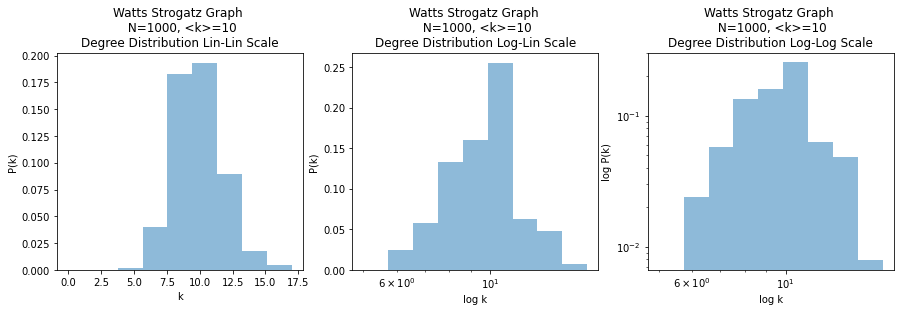

In [ ]:
plot_degree_distributions(ws_n_1000_k_10, "Watts Strogatz Graph \n N=1000, <k>=10", n_bins=10, density=True)

### 2.3 Real World Graphs
#### 2.3.1 Facebook Graph

In [ ]:
facebook_friendship_graph = load_graph("graph_facebook.gml")

In [ ]:
quantify_graph(facebook_friendship_graph)

Number of Nodes: 4039
Number of Edges: 88234
Is directed: False
Is weighted: False
Is connected: True
Density: 1.082%
Diameter: 8
Min Node Degree: 1
Max Node Degree: 1045
Average Node Degree: <k> ≈ 43.69
Average Clustering Coefficient: 0.6055
Degree Assortativity Coefficient: 0.0636
Fitted power law-exponent: Ɣ ≈ 2.51
Standard error of fit: σ ≈ 0.0427


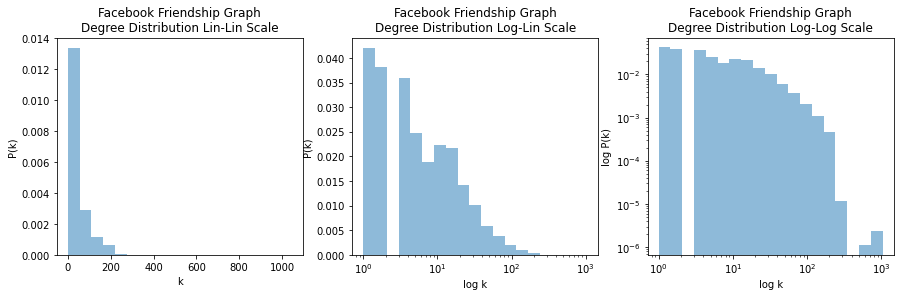

In [ ]:
plot_degree_distributions(facebook_friendship_graph, "Facebook Friendship Graph", n_bins=20, density=True)

#### 2.3.2 Escorts Graph

In [ ]:
sex_escort_graph = load_graph("graph_escort.gml")

In [ ]:
quantify_graph(sex_escort_graph)

Number of Nodes: 16730
Number of Edges: 39044
Is directed: False
Is weighted: False
Is connected: False
Density: 0.0279%
Min Node Degree: 1
Max Node Degree: 305
Average Node Degree: <k> ≈ 4.67
Average Clustering Coefficient: 0.0
Degree Assortativity Coefficient: -0.1097
Fitted power law-exponent: Ɣ ≈ 2.87
Standard error of fit: σ ≈ 0.0758


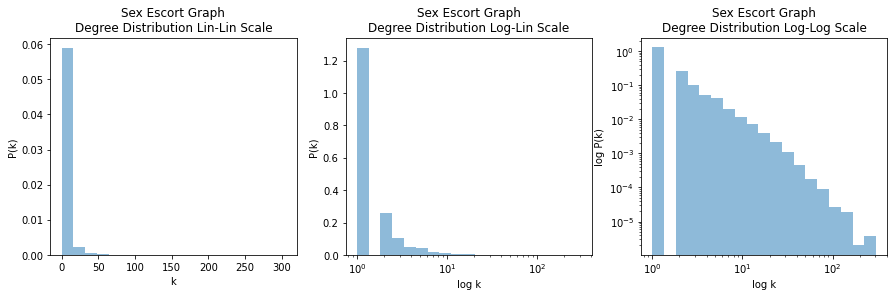

In [ ]:
plot_degree_distributions(sex_escort_graph, "Sex Escort Graph", n_bins=20, density=True)

#### 2.3.3 Contact Tracing Graph

In [ ]:
def read_haslemere_graph():
  # First we read the CSV: Contact tracing data over 3 days
  tracing_df = pd.read_csv("https://raw.githubusercontent.com/skissler/haslemere/master/Kissler_DataS1.csv")
  tracing_df.info()
  tracing_graph = nx.Graph()
  # Then we add for every contact <= 5m an edge with the attribute distance that shows the exact distance
  for index, row in tracing_df.iterrows():
      if row[3] <= 5 and not tracing_graph.has_edge(row[1], row[2]):
        tracing_graph.add_edge(int(row[1]), int(row[2]), distance=row[3], timestep=row[0])
  return tracing_graph
contact_tracing_graph = read_haslemere_graph()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102830 entries, 0 to 102829
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   1       102830 non-null  int64
 1   1.1     102830 non-null  int64
 2   390     102830 non-null  int64
 3   17      102830 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [ ]:
quantify_graph(contact_tracing_graph)

Number of Nodes: 418
Number of Edges: 1350
Is directed: False
Is weighted: False
Is connected: False
Density: 1.549%
Min Node Degree: 1
Max Node Degree: 37
Average Node Degree: <k> ≈ 6.46
Average Clustering Coefficient: 0.2032
Degree Assortativity Coefficient: 0.061
Fitted power law-exponent: Ɣ ≈ 3.0
Standard error of fit: σ ≈ 0.1566


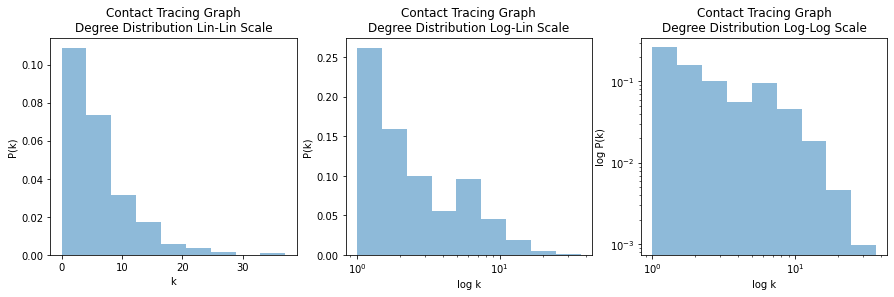

In [ ]:
plot_degree_distributions(contact_tracing_graph, "Contact Tracing Graph", n_bins=10, density=True)

## 3. Experiments
### 3.1 Experiment 1

In [ ]:
def gillespie_wellmixed(N, recovery_rate, infection_rates, initial_infection_rate, r):
    # creating 20 values between 0 and 0.3
    betas = infection_rates
    
    avg_fraction_per_beta = []
    
    for beta in betas:
        R_per_run = []  

        for i in range (0,r):
            S_Init = np.zeros(int(N-N*initial_infection_rate),dtype=int)
            I_Init = np.ones(int(N*initial_infection_rate),dtype=int)
            populationvector = np.append(S_Init,I_Init)
            np.random.shuffle(populationvector)
            time = 0

            while np.sum( populationvector == 1 ) > 0:
                # calculating aggregated infection and recovery rates
                infection_rate = ((np.sum( populationvector == 1 ))) * beta * ((np.sum( populationvector == 0 )))/N
                total_recovery_rate = ((np.sum( populationvector == 1 ))) * recovery_rate
                total_rate = infection_rate + total_recovery_rate
                next_event = -np.log(rnd.random()) / total_rate
                time += next_event

                if rnd.random() < (infection_rate / total_rate):
                    # infection takes place
                    index_S = np.where(populationvector == 0)
                    populationvector[index_S[0][0]] = 1

                else:
                    # recovery takes place
                    index_infected = np.where(populationvector == 1) 
                    populationvector[index_infected[0][0]] = 2            

                infection_rate = ((np.sum( populationvector == 1 ))) * beta * ((np.sum( populationvector == 0 )))/N
                total_recovery_rate = ((np.sum( populationvector == 1 ))) * recovery_rate
                total_rate = infection_rate + total_recovery_rate


            S= np.sum( populationvector == 0 )
            I= np.sum( populationvector == 1 )
            R= np.sum( populationvector == 2 )
            #print(time,S,I,R)
            R_per_run.append(R)
            
        avg_fraction_per_beta.append(np.mean(R_per_run)/N)
    return avg_fraction_per_beta 

In [ ]:
def simulate_epidemic_scope(graph, infection_rates, n_iterations=10):          
  fraction_recovered = []
  recovery_rate = 1
  N = graph.number_of_nodes()
  for infection_rate in infection_rates:
    Rs = []
    for n_iteration in range(n_iterations):
      initial_infecteds = random.sample(list(graph.nodes()), int(0.01*N))
      t, S, I, R = EoN.Gillespie_SIR(graph, infection_rate, recovery_rate, initial_infecteds = initial_infecteds)
      Rs.append(np.max(R))
    fraction_recovered.append(np.mean(Rs)/N)
  return fraction_recovered

In [ ]:
infection_rates=np.linspace(0, 0.3, 20)

In [ ]:
fraction_recovered_01 = simulate_epidemic_scope(ba_n_1000_k_10, infection_rates=infection_rates) 

In [ ]:
fraction_recovered_02 = simulate_epidemic_scope(er_n_1000_k_10, infection_rates=infection_rates) 

In [ ]:
fraction_recovered_03 = simulate_epidemic_scope(ws_n_1000_k_10, infection_rates=infection_rates) 

In [ ]:
fraction_recovered_04 = gillespie_wellmixed(1000, 0.1, infection_rates, 0.02, 20)

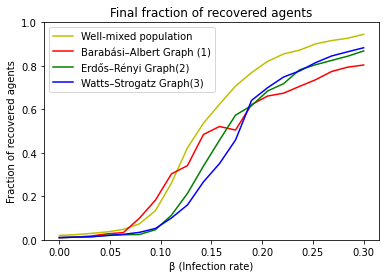

In [ ]:
plt.plot(infection_rates, fraction_recovered_04, label="Well-mixed population", color="y")
plt.plot(infection_rates, fraction_recovered_01, label="Barabási–Albert Graph (1)", color="r")
plt.plot(infection_rates, fraction_recovered_02, label="Erdős–Rényi Graph(2)", color="g")
plt.plot(infection_rates, fraction_recovered_03, label="Watts–Strogatz Graph(3)", color="b")
plt.title('Final fraction of recovered agents')
plt.xlabel("β (Infection rate)")
plt.ylabel("Fraction of recovered agents")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [ ]:
fraction_recovered_04 = simulate_epidemic_scope(facebook_friendship_graph, infection_rates=infection_rates) 

In [ ]:
fraction_recovered_05 = simulate_epidemic_scope(sex_escort_graph, infection_rates=infection_rates) 

In [ ]:
fraction_recovered_06 = simulate_epidemic_scope(contact_tracing_graph, infection_rates=infection_rates) 

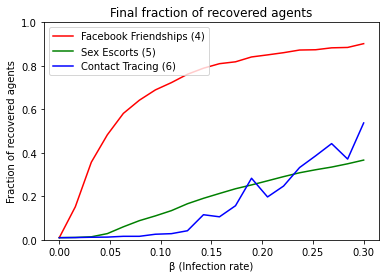

In [ ]:
plt.plot(infection_rates, fraction_recovered_04, label="Facebook Friendships (4)", color="r")
plt.plot(infection_rates, fraction_recovered_05, label="Sex Escorts (5)", color="g")
plt.plot(infection_rates, fraction_recovered_06, label="Contact Tracing (6)", color="b")
plt.title('Final fraction of recovered agents')
plt.xlabel("β (Infection rate)")
plt.ylabel("Fraction of recovered agents")
plt.ylim(0, 1)
plt.legend(loc="upper left")
plt.show()

In [ ]:
def SIR_network_comparison(networks, parameter_combinations):
  for parameter_combination in parameter_combinations:    
      infection_rate = parameter_combination.get("infection_rate", DEFAULT_INFECTION_RATE)
      recovery_rate = parameter_combination.get("recovery_rate", DEFAULT_RECOVERY_RATE)
      
      plt.ylim(0,1)

      i = 0
      linestyles=['solid', 'dotted', 'dashed']
      for network_name, network in networks.items():
        N = network.number_of_nodes()
        initial_infected = random.sample(list(network.nodes()), int(0.01*N))

        t, S, I, R = EoN.Gillespie_SIR(network, infection_rate, recovery_rate, initial_infecteds = initial_infected, tmax=10)

        plt.plot(t, S/N, color=S_COLOR, linestyle=linestyles[i])
        plt.plot(t, I/N, color=I_COLOR, linestyle=linestyles[i], label=network_name)
        i=i+1

      plt.legend()
      ax = plt.gca()
      leg = ax.get_legend()
      leg.legendHandles[0].set_color('black')
      leg.legendHandles[1].set_color('black')
      leg.legendHandles[2].set_color('black')
      plt.title("β: {}, γ: {}".format(infection_rate, recovery_rate))
      plt.xlabel("Time")
      plt.ylabel("Fraction of recovered agents")
      plt.show()

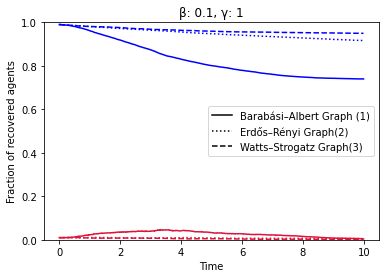

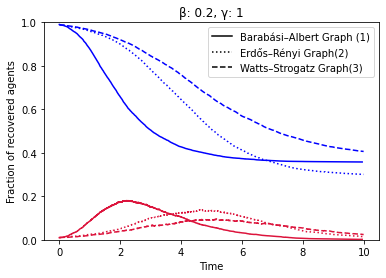

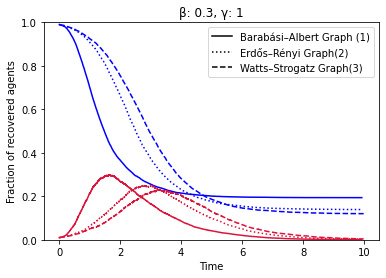

In [ ]:
graphs = {
  "Barabási–Albert Graph (1)": barabasi_albert_graph(10000, 10),
  "Erdős–Rényi Graph(2)": erdos_renyi_graph(10000, 10),
  "Watts–Strogatz Graph(3)": nx.watts_strogatz_graph(10000, 10, p=0.5)
}

parameter_combinations = [
  {"infection_rate": 0.1, "recovery_rate": 1},
  {"infection_rate": 0.2, "recovery_rate": 1},
  {"infection_rate": 0.3, "recovery_rate": 1},
]

SIR_network_comparison(graphs, parameter_combinations)

### Experiment 2

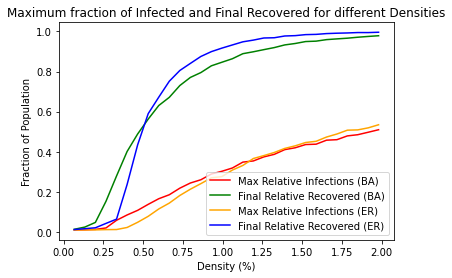

In [4]:
def compare_average_degree_vs_max_infections_on_ba_graph(n_nodes, degrees, n_iter = 10):
  ys_infected = []
  ys_rec = []
  ys_infected_er = []
  ys_rec_er = []
  xes = []
  for deg in degrees: 
    loop_elems_inf = []
    loop_elems_rec = []
    loop_elems_inf_er = []
    loop_elems_rec_er = []
    for i in range(n_iter):
      gr_ba = nx.barabasi_albert_graph(n_nodes, deg)
      gr_er = nx.generators.random_graphs.gnm_random_graph(n_nodes, deg * n_nodes)
      if i == 0:
        xes.append(nx.density(gr_ba) * 100)
      t, S, I, R = EoN.Gillespie_SIR(gr_ba, 0.1, 1.0,rho=0.01)
      loop_elems_inf.append(max(I))
      loop_elems_rec.append(max(R))

      t, S, I, R = EoN.Gillespie_SIR(gr_er, 0.1, 1.0,rho=0.01)
      loop_elems_inf_er.append(max(I))
      loop_elems_rec_er.append(max(R))

    ys_infected.append(sum(loop_elems_inf) / n_iter / n_nodes)
    ys_infected_er.append(sum(loop_elems_inf_er) / n_iter / n_nodes)
    ys_rec.append(sum(loop_elems_rec) / n_iter / n_nodes)
    ys_rec_er.append(sum(loop_elems_rec_er) / n_iter / n_nodes)
  plt.plot(xes, ys_infected, label="Max Relative Infections (BA)", color="red")
  plt.plot(xes, ys_rec, label="Final Relative Recovered (BA)", color="green")
  plt.plot(xes, ys_infected_er, label="Max Relative Infections (ER)", color="orange")
  plt.plot(xes, ys_rec_er, label="Final Relative Recovered (ER)", color="blue")
  plt.title("Maximum fraction of Infected and Final Recovered for different Densities")
  plt.xlabel("Density (%)")
  plt.ylabel("Fraction of Population")
  plt.legend()
  plt.show()

compare_average_degree_vs_max_infections_on_ba_graph(3000, np.linspace(1, 30, num=30).astype(int).tolist(), n_iter=10)

### Experiment 3

Density before: 0.013248860731354896
Density after: 0.001391130376792264


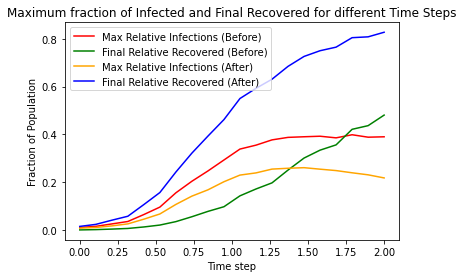

In [7]:
def compare_lockdown_at_different_timesteps(n_nodes, original_avg_deg=20, cut_to=5, n_iter=10, delay_relative=0.333):
  max_inf_before = []
  max_rec_before = []
  max_inf_after = []
  max_rec_after = []
  ts = np.linspace(0, 2, num=20).tolist()
  for t_stop in ts: 
    loop_elems_inf_bef = []
    loop_elems_rec_bef = []
    loop_elems_inf_after = []
    loop_elems_rec_after = []
    for i in range(n_iter):
      gr_ba_before = nx.barabasi_albert_graph(n_nodes, original_avg_deg)
      if i == 0 and t_stop == ts[0]:
        print(f"Density before: {nx.density(gr_ba_before)}")
      state_before_lockdown = EoN.Gillespie_SIR(gr_ba_before, 0.1, 1.0, rho=0.01, tmin=0, tmax=t_stop, return_full_data=True)
      loop_elems_inf_bef.append(max(state_before_lockdown.I()))
      loop_elems_rec_bef.append(max(state_before_lockdown.R()))
      status_dict = {node: state_before_lockdown.node_status(node, max(state_before_lockdown.t())) for node in gr_ba_before.nodes}

      gr_after = gr_ba_before.copy()
      all_degs = list(gr_after.degree)
      all_degs.sort(key=lambda x: x[1], reverse=True)
      edges_to_remove = set()
      for pair in all_degs:
        gr_after.remove_edges_from(list(gr_after.edges(pair[0]))[cut_to:])

      if i == 0 and t_stop == ts[0]:
        print(f"Density after: {nx.density(gr_after)}")
      t, S, I, R = EoN.Gillespie_SIR(gr_after, 0.1, 1.0,
                                     initial_infecteds=[node for node in gr_ba_before.nodes if status_dict[node] == "I"],
                                     initial_recovereds=[node for node in gr_ba_before.nodes if status_dict[node] == "R"])
      delay_absolute = int(len(t) * delay_relative)
      loop_elems_inf_after.append(max(I[delay_absolute:]))
      loop_elems_rec_after.append(max(R))

    max_inf_before.append(sum(loop_elems_inf_bef) / n_iter / n_nodes)
    max_rec_before.append(sum(loop_elems_rec_bef) / n_iter / n_nodes)
    max_inf_after.append(sum(loop_elems_inf_after) / n_iter / n_nodes)
    max_rec_after.append(sum(loop_elems_rec_after) / n_iter / n_nodes)
  plt.plot(ts, max_inf_before, label="Max Relative Infections (Before)", color="red")
  plt.plot(ts, max_rec_before, label="Final Relative Recovered (Before)", color="green")
  plt.plot(ts, max_inf_after, label="Max Relative Infections (After)", color="orange")
  plt.plot(ts, max_rec_after, label="Final Relative Recovered (After)", color="blue")
  plt.title("Maximum fraction of Infected and Final Recovered for different Time Steps")
  plt.xlabel("Time step")
  plt.ylabel("Fraction of Population")
  plt.legend()
  plt.show()

compare_lockdown_at_different_timesteps(3000, original_avg_deg=20 ,n_iter=10, delay_relative=1./3,cut_to=5)

### Experiment 4
=> Research the effect of the sirs SIRS Epidemic

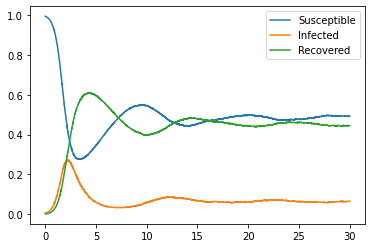

In [ ]:
N = 50000
G = nx.fast_gnp_random_graph(N, 5./(N-1))

H = nx.DiGraph()  #DiGraph showing possible transitions that don't require an interaction
H.add_edge('I', 'R', rate = 1.4)   #I->R
H.add_edge('R', 'S', rate = 0.2)   #R->S

J = nx.DiGraph()    #DiGraph showing transition that does require an interaction.
J.add_edge(('I', 'S'), ('I', 'I'), rate = 1)  #IS->II

IC = defaultdict(lambda: 'S')
for node in range(200):
    IC[node] = 'I'

return_statuses = ('S', 'I', 'R')

t, S, I, R = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses, tmax = 30)

S_ratios = S/N
I_ratios = I/N
R_ratios = R/N

plt.plot(t, S/N, label = 'Susceptible')
plt.plot(t, I/N, label = 'Infected')
plt.plot(t, R/N, label = 'Recovered')
plt.legend()

In [ ]:
N = 50000
G = nx.fast_gnp_random_graph(N, 5./(N-1))

H = nx.DiGraph()  #DiGraph showing possible transitions that don't require an interaction
H.add_edge('I', 'R', rate = 1.4)   #I->R
H.add_edge('R', 'S', rate = 0.2)   #R->S

J = nx.DiGraph()    #DiGraph showing transition that does require an interaction.
J.add_edge(('I', 'S'), ('I', 'I'), rate = 1)  #IS->II

IC = defaultdict(lambda: 'S')
for node in range(200):
    IC[node] = 'I'

return_statuses = ('S', 'I', 'R')

t, S, I, R = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses, tmax = 30)

S_ratios = S/N
I_ratios = I/N
R_ratios = R/N

plt.plot(t, S/N, label = 'Susceptible')
plt.plot(t, I/N, label = 'Infected')
plt.plot(t, R/N, label = 'Recovered')
plt.legend()